# Import

In [1]:
import os
import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import pydicom
from PIL import Image
import cv2

from glob import glob
from tqdm import tqdm

from matplotlib import pyplot as plt


IMG_EXTENSION = ['.dcm', '.DCM']


def check_extension(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSION)


def load_scans_path(folder_path):
    """
    find 'IMG_EXTENSION' file paths in folder.
    return list
    
    """
    
    img_paths = []
    assert os.path.isdir(folder_path), '%s is not a valid directory'

    for root, _, fnames in sorted(os.walk(folder_path)):
        for fname in fnames:
            if check_extension(fname):
                path = os.path.join(root, fname)
                img_paths.append(path)
    return img_paths[:]


def load_ct_scans(patient_folder_path):
    """
    Function of Loading CT-scans "per patient"
    patient path to CT slices(HU)
    input: patient folder path -> list or tuple
    output: File Meta Information, CT sclices -> tuple
    """
    # call all image paths in directory
    dcm_paths = load_scans_path(patient_folder_path)
    
    slices = [pydicom.read_file(dcm_path, force=True) for dcm_path in dcm_paths]
    
    # **Sort the slices in ascending order
    
    for idx, sl in enumerate(slices):
        try:
            _ = sl.ImagePositionPatient[2]
        except AttributeError:
            slices.pop(idx)
            print(idx)
        
    slices.sort(key = lambda x: float(x.ImagePositionPatient[2]))
        
    # stack slices
    images = np.stack([file.pixel_array for file in slices])
    images = images.astype(np.int16)
    
    # convert to HU
    intercept = slices[0].RescaleIntercept
    slope = slices[0].RescaleSlope
    hu_images = images.astype(np.float64) * slope + intercept
    hu_images = set_outside_scanner_to_air(hu_images.astype(np.int16))
    
    # return header of first dicom and stacked CT slices
    return slices[0], hu_images


def set_outside_scanner_to_air(hu_pixelarrays):
    """
    Pixel Padding Value Attribute(0028,0120) -> air
    """
    hu_pixelarrays[hu_pixelarrays < -1024] = -1024
    
    return hu_pixelarrays


def transform_to_hu(dicom_info, image):
    image = set_outside_scanner_to_air(image)
    
    intercept = dicom_info.RescaleIntercept
    slope = dicom_info.RescaleSlope
    hu_image = image.astype(np.float64) * slope + intercept
    hu_image = set_outside_scanner_to_air(hu_image.astype(np.int16))
    return hu_image


def windowing(img, window):
    w_level, w_width = window
    w_min = w_level - (w_width / 2)
    w_max = w_level + (w_width / 2)
    window_image = img.copy()
    window_image[window_image < w_min] = w_min
    window_image[window_image > w_max] = w_max

    return window_image
    
    
def dcms_to_imgs(dcms):
    dcms.sort(key = lambda x: float(x.ImagePositionPatient[2]))
    images = np.stack([file.pixel_array for file in dcms])
    images = images.astype(np.int16)

    # convert to HU
    intercept = dcms[0].RescaleIntercept
    slope = dcms[0].RescaleSlope
    hu_images = images.astype(np.float64) * slope + intercept
    hu_images = set_outside_scanner_to_air(hu_images.astype(np.int16))
    return hu_images


def sample_stack(stacks, cols=10, start_with=0, show_every=1, vmin=-1000, vmax=1000):
    rows = len(stacks)//cols
    fig,ax = plt.subplots(rows+1,cols,figsize=[25,rows*3])
    for i in range(len(stacks)):
        ind = start_with + i*show_every
        ax[i//cols,i % cols].set_title(f'{stacks[ind].get("SeriesNumber")}')
        ax[i//cols,i % cols].imshow(stacks[ind].pixel_array, vmin=vmin, vmax=vmax,cmap='gray')
        ax[i//cols,i % cols].axis('off')        
    plt.show()
    
    
def imgs_stack(stacks, cols=10, start_with=0, show_every=1):
    rows = len(stacks)//cols
    fig,ax = plt.subplots(rows+1,cols,figsize=[40,rows*5])
    for i in range(len(stacks)):
        ind = start_with + i*show_every
        ax[i//cols,i % cols].imshow(stacks[ind],cmap='gray')
        ax[i//cols,i % cols].axis('off')        
    plt.show()

In [36]:
for i in tqdm(range(len(glob(BASE_DIR)))):

    BASE_DIR = "./ctpel/*"
    path = f"{glob(BASE_DIR)[i]}/im_1/*.dcm"

    mask_path = glob(f"{glob(BASE_DIR)[i]}/im_3/*.dcm")
    mask_dcm = pydicom.dcmread(mask_path[0], force=True)
    masked_slices = mask_dcm[0x008, 0x1115][0][0x008, 0x114a]

    slices = []
    for fname in glob(path):
        slices.append(pydicom.dcmread(fname, force=True))
    slices = sorted(slices, key=lambda s: s[0x020, 0x032][-1])

    uids_masked = []
    for s in masked_slices:
        uids_masked.append(s[0x008, 0x1155].value)

    uids_all = []
    for s in slices:
        uids_all.append(s[0x008, 0x018].value)

    roi = []
    for j in uids_masked:
        roi.append(uids_all.index(j))

    roi_slices = slices[:]
    roi_imgs = dcms_to_imgs(roi_slices)
    window_roi_img = windowing(roi_imgs, [600, 1800])

    img_shape = list(roi_slices[0].pixel_array.shape)
    img_shape.append(len(roi_slices))

    roi_img3d = np.zeros(img_shape)

    for j, s in enumerate(window_roi_img):
            roi_img3d[:, :, -(j+1)] = s

    roi_img3d = (roi_img3d - np.min(roi_img3d)) / (np.max(roi_img3d) - np.min(roi_img3d))
    roi_img3d = np.array(roi_img3d*255).astype(np.uint8)

    for idx in range(roi_img3d.shape[-1]):
        Image.fromarray(roi_img3d[:, :, idx]).convert("L").resize((512, 512)).save(f"axial_slices/{glob(BASE_DIR)[i].split('/')[-1]}_{idx:03}.png")

    segment_dict = {x: [] for x in range(1,6)}
    for s in mask_dcm[0x5200, 0x9230]:
        uid = s[0x008, 0x9124][0][0x008, 0x2112][0][0x008, 0x1155].value
        segment_num = s[0x062, 0x00a][0][0x062, 0x00b].value

        segment_dict[segment_num].append(uid)

    roi_dict = {x: [] for x in range(1,6)}
    for seg_num in segment_dict:
        for j in segment_dict[seg_num]:
            roi_dict[seg_num].append(uids_all.index(j))

    mask_arr = mask_dcm.pixel_array
    segment_arr_dict = dict()
    idx = 0
    for seg_num in roi_dict:
        seg_img3d = np.zeros(img_shape)
        for j in roi_dict[seg_num]:
            seg_img3d[:, :, -(j+1)] = mask_arr[idx]
            idx += 1
        segment_arr_dict[seg_num] = seg_img3d

    img_dict = dict()
    for j in range (1,6):
        img_dict[j]=np.array(segment_arr_dict[j]*255).astype(np.uint8)
        for idx in range(img_dict[j].shape[-1]):
            Image.fromarray(img_dict[j][:, :, idx]).convert("L").resize((512, 512)).save(f"axial_masks/{glob(BASE_DIR)[i].split('/')[-1]}_{idx:03}_{j}.png")

100%|██████████| 90/90 [3:23:54<00:00, 135.94s/it]  


In [6]:
i = 0

BASE_DIR = "./ctpel/*"
path = f"{glob(BASE_DIR)[i]}/im_1/*.dcm"

mask_path = glob(f"{glob(BASE_DIR)[i]}/im_3/*.dcm")
mask_dcm = pydicom.dcmread(mask_path[0], force=True)
masked_slices = mask_dcm[0x008, 0x1115][0][0x008, 0x114a]

In [7]:
slices = []
for fname in glob(path):
    slices.append(pydicom.dcmread(fname, force=True))
slices = sorted(slices, key=lambda s: s[0x020, 0x032][-1])

In [8]:
uids_masked = []
for s in masked_slices:
    uids_masked.append(s[0x008, 0x1155].value)

uids_all = []
for s in slices:
    uids_all.append(s[0x008, 0x018].value)

roi = []
for j in uids_masked:
    roi.append(uids_all.index(j))

In [9]:
roi_slices = slices[:]
roi_imgs = dcms_to_imgs(roi_slices)
window_roi_img = windowing(roi_imgs, [600, 1800])

img_shape = list(roi_slices[0].pixel_array.shape)
img_shape.append(len(roi_slices))

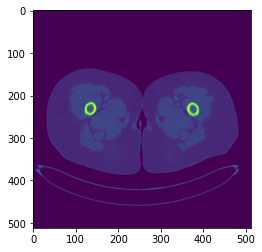

In [13]:
plt.imshow(window_roi_img[0])

In [14]:
roi_img3d = np.zeros(img_shape)

for j, s in enumerate(window_roi_img):
        roi_img3d[:, :, -(j+1)] = s

In [15]:
roi_img3d = (roi_img3d - np.min(roi_img3d)) / (np.max(roi_img3d) - np.min(roi_img3d))
roi_img3d = np.array(roi_img3d*255).astype(np.uint8)

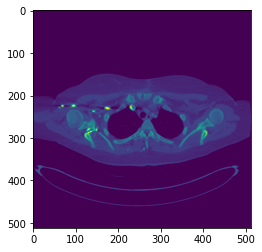

In [23]:
plt.imshow(roi_img3d[:, :, 50])

In [26]:
for idx in range(roi_img3d.shape[-1]):
    Image.fromarray(roi_img3d[:, :, idx]).convert("L").resize((512, 512)).save(f"axial_slices/{glob(BASE_DIR)[i].split('/')[-1]}_{idx:03}.png")

In [27]:
segment_dict = {x: [] for x in range(1,6)}
for s in mask_dcm[0x5200, 0x9230]:
    uid = s[0x008, 0x9124][0][0x008, 0x2112][0][0x008, 0x1155].value
    segment_num = s[0x062, 0x00a][0][0x062, 0x00b].value

    segment_dict[segment_num].append(uid)

roi_dict = {x: [] for x in range(1,6)}
for seg_num in segment_dict:
    for j in segment_dict[seg_num]:
        roi_dict[seg_num].append(uids_all.index(j))

In [28]:
mask_arr = mask_dcm.pixel_array
segment_arr_dict = dict()
idx = 0
for seg_num in roi_dict:
    seg_img3d = np.zeros(img_shape)
    for j in roi_dict[seg_num]:
        seg_img3d[:, :, -(j+1)] = mask_arr[idx]
        idx += 1
    segment_arr_dict[seg_num] = seg_img3d

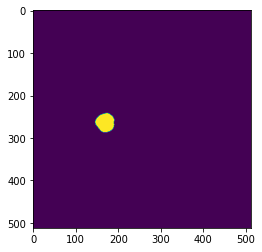

In [33]:
plt.imshow(segment_arr_dict[1][:, :, 500])

In [35]:
img_dict = dict()
for j in range (1,6):
    img_dict[j]=np.array(segment_arr_dict[j]*255).astype(np.uint8)
    for idx in range(img_dict[j].shape[-1]):
        Image.fromarray(img_dict[j][:, :, idx]).convert("L").resize((512, 512)).save(f"axial_masks/{glob(BASE_DIR)[i].split('/')[-1]}_{idx:03}_{j}.png")